Xây dựng Decision Tree bằng thuật toán C4.5

khai báo thư viện

In [13]:
import numpy as np
import pandas as pd

class Node

In [14]:
class Node:
    def __init__(self, attribute=None, threshold=None):
        self.attribute = attribute
        self.threshold = threshold
        self.children = []
        self.leaf = False
        self.label = None

Hàm entropy()

In [15]:
def entropy(data: pd.DataFrame, label):
    all_count = len(data)
    class_counts = data[label].value_counts()
    class_probabilities = class_counts / all_count
    class_probabilities += 1e-10  
    return -np.sum(class_probabilities * np.log2(class_probabilities))

Hàm tính entropy của một tập dữ liệu: Input: data: tập dữ liệu, label: nhãn => Ouput: giá trị entropy 
![Screenshot 2024-05-15 091444.png](<attachment:Screenshot 2024-05-15 091444.png>)
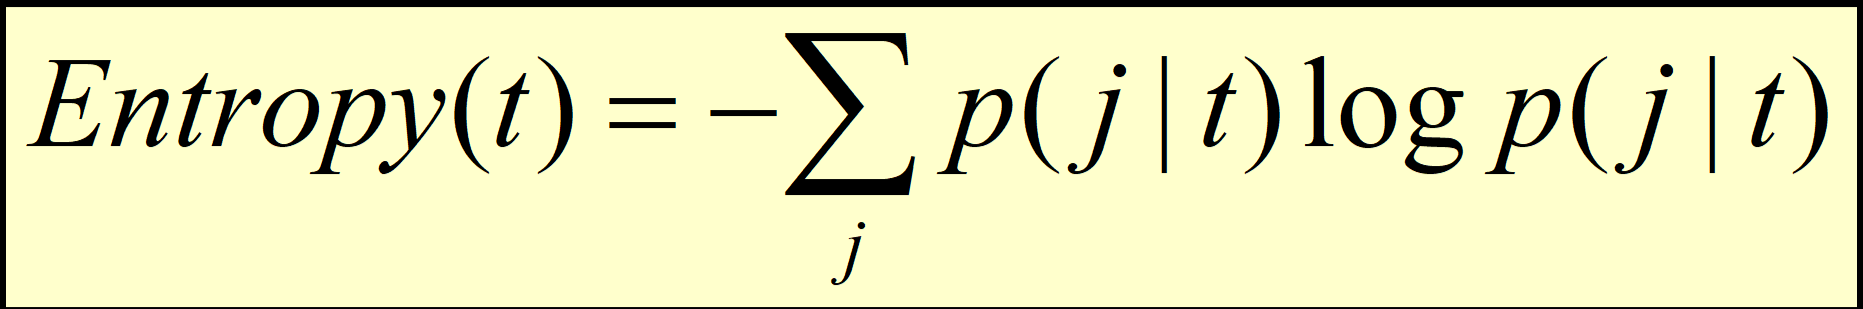

Hàm gain_ratio()

In [16]:
def gain_ratio(data: pd.DataFrame, label):
    features = data.columns.difference([label])
    ret = {}

    curr_entropy = entropy(data, label)

    for feature in features:
        intrinsic_value = 0
        if data[feature].dtype == 'object':
            feature_count = data[feature].value_counts(normalize=True)
            feature_entropy = np.sum([entropy(data[data[feature] == value], label) * feature_count[value] for value in feature_count.index])
            intrinsic_value = -np.sum(feature_count * np.log2(feature_count))  
        else:  
            sorted_data = data.sort_values(by=feature)
            thresholds = sorted_data[feature].unique()
            feature_entropy = float('inf')
            best_threshold = None

            for i in range(1, len(thresholds)):
                threshold = thresholds[i]
                below_threshold = data[data[feature] <= threshold]
                above_threshold = data[data[feature] > threshold]

                if len(below_threshold) > 0 and len(above_threshold) > 0:
                    weighted_entropy = (len(below_threshold) / len(data) * entropy(below_threshold, label) + len(above_threshold) / len(data) * entropy(above_threshold, label))

                    if weighted_entropy < feature_entropy:
                        feature_entropy = weighted_entropy
                        best_threshold = threshold

            if best_threshold is not None:
                below_threshold = data[data[feature] <= best_threshold]
                above_threshold = data[data[feature] > best_threshold]
                if len(below_threshold) != 0 and len(above_threshold) !=0:
                    intrinsic_value = -((len(below_threshold) / len(data)) * np.log2(len(below_threshold) / len(data)) + (len(above_threshold) / len(data)) * np.log2(len(above_threshold) / len(data)))
                else:
                    intrinsic_value = 0
        gain = curr_entropy - feature_entropy
        if intrinsic_value != 0:
            ret[feature] = gain / intrinsic_value
        else:
            ret[feature] = 0
    return ret

Hàm gain_ratio tính tỉ lệ lượng thông tin: Input: data: tập dữ liệu đầu vào; label: tập nhãn => Output: Trả về dictionary chứa gain ratio của các thuộc tính.
công thức tính gain ratio:

![Screenshot 2024-05-15 091725.png](<attachment:Screenshot 2024-05-15 091725.png>)

công thức tính information gain:
![Screenshot 2024-05-15 093115.png](<attachment:Screenshot 2024-05-15 093115.png>)

công thức tính SplitINF:
![Screenshot 2024-05-15 091738.png](<attachment:Screenshot 2024-05-15 091738.png>)
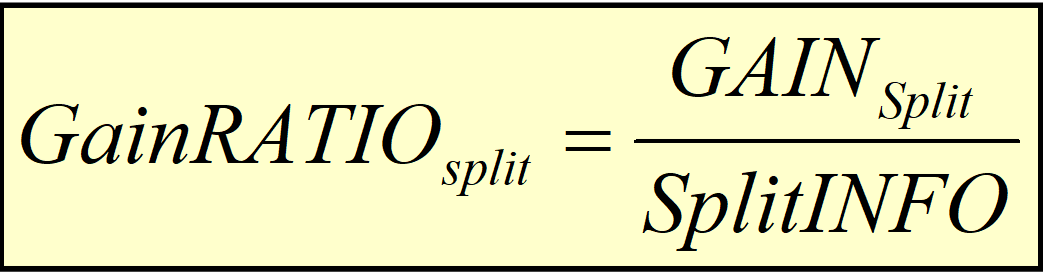
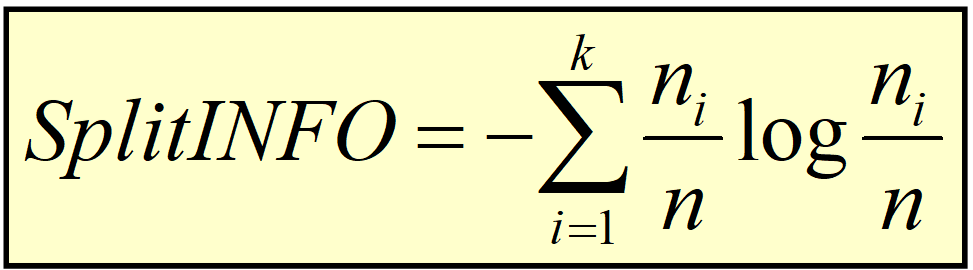
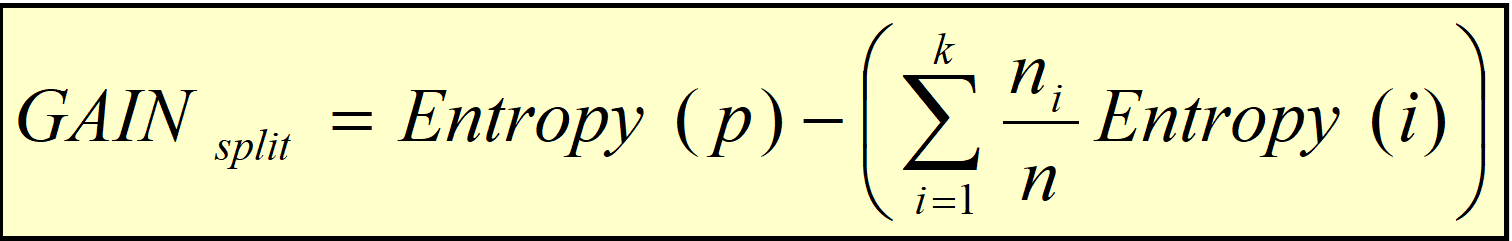

Hàm select_best_attribute()

In [17]:
def select_best_attribute(data, label):
    gain_ratios = gain_ratio(data, label)
    max_gain_ratio_attr = max(gain_ratios, key=gain_ratios.get)
    
    return max_gain_ratio_attr

Hàm select_best_attribute: Input: data; label => Output: thuộc tính có giá trị gain ratios cao nhất

Hàm decision_tree_algorithm_C45()

In [18]:
def decision_tree_algorithm_C45(root, data: pd.DataFrame, label, min_samples_split=2):
    if len(data) == 0: 
        root.label = "Failure"
        return root

    elif len(set(data[label])) == 1: 
        root.leaf = True
        root.label = data[label].iloc[0]
        return root

    elif len(data.columns) == 1 or len( data) < min_samples_split: 
        root.leaf = True
        root.label = data[label].mode()[0]
        return root

    else:
        best_attr = select_best_attribute(data, label)
        root.attribute = best_attr

        if data[best_attr].dtype == 'object': 
            for attr_val in data[best_attr].unique():
                subset = data[data[best_attr] == attr_val].drop(columns=[best_attr])
                child_node = Node(attribute=best_attr, threshold=attr_val)
                root.children.append(child_node)
                decision_tree_algorithm_C45(child_node, subset, label, min_samples_split)
        else:  
            sorted_data = data.sort_values(by=best_attr)
            thresholds = sorted_data[best_attr].unique()
            best_threshold = None
            feature_entropy = float('inf')

            for i in range(1, len(thresholds)):
                threshold = thresholds[i]
                below_threshold = data[data[best_attr] <= threshold]
                above_threshold = data[data[best_attr] > threshold]

                if len(below_threshold) > 0 and len(above_threshold) > 0:
                    weighted_entropy = (len(below_threshold) / len(data) * entropy(below_threshold, label) + len(above_threshold) / len(data) * entropy(above_threshold, label))

                    if weighted_entropy < feature_entropy:
                        feature_entropy = weighted_entropy
                        best_threshold = threshold

            if best_threshold is not None:
                below_threshold = data[data[best_attr] <= best_threshold]
                above_threshold = data[data[best_attr] > best_threshold]
                root.threshold = best_threshold

                child_node_below = Node(attribute=best_attr, threshold=best_threshold)
                root.children.append(child_node_below)
                decision_tree_algorithm_C45(child_node_below, below_threshold, label, min_samples_split)

                child_node_above = Node(attribute=best_attr, threshold=best_threshold)
                root.children.append(child_node_above)
                decision_tree_algorithm_C45(child_node_above, above_threshold, label, min_samples_split)

        return root

Hàm decision_tree_algorithm xây dựng cây quyết định từ dữ liệu đầu vào. Input: root (nút); data (dữ liệu trainning); label (nhãn), min_samples_split (số mấu tối tiểu để phân chia) => Output: cây quyết định

Hàm prume_Tree()

In [19]:
def prune_tree(node):
    if not node.leaf:
        for child in node.children:
            prune_tree(child)
        if all(child.leaf for child in node.children): 
            child_labels = [child.label for child in node.children]
            if len(set(child_labels)) == 1:
                node.leaf = True
                node.label = child_labels[0]
                node.children = []
                node.attribute = None
                node.threshold = None

Hàm prune_tree tỉa cây quyết định để loại bỏ các nút không cần thiết

Hàm print_tree()

In [20]:
def print_tree(node, depth=0):
    if node is None:
        return
    indent = "  " * depth
    if node.leaf:
        print(f"{indent}Leaf Node - Label: {node.label}")
    else:
        print(f"{indent}Node - Attribute: {node.attribute}, Threshold: {node.threshold}")
        for child in node.children:
            print_tree(child, depth + 1)

Hàm print_tree hiển thị cấu trúc cây quyết định

Hàm predict()

In [21]:
def predict(node, data_test):
    predictions = []
    for _, instance in data_test.iterrows():
        curr_node = node
        while not curr_node.leaf:
            if curr_node.attribute in instance:
                attr_val = instance[curr_node.attribute]
                if isinstance(attr_val, str):
                    found = False
                    for child in curr_node.children:
                        if child.threshold == attr_val:
                            curr_node = child
                            found = True
                            break
                    if not found:
                        break
                else:
                    if attr_val <= curr_node.threshold:
                        curr_node = curr_node.children[0]
                    else:
                        curr_node = curr_node.children[1]
            else:
                break
        predictions.append(curr_node.label)
    return predictions

Hàm predict dự đoán nhãn cho dữ liệu kiểm thử dựa trên cây quyết định

Tạo nút gốc và tải dữ liệu

In [22]:
root_node = Node()

data = pd.read_csv("D:\Student\project\data-mining\Data_Set\processed.csv")
print(data)

       pm2.5  pm10   so2   no2     co  dewp  wspm  label
0        4.0   4.0   4.0   7.0  300.0 -18.8   4.4    0.0
1        8.0   8.0   4.0   7.0  300.0 -18.2   4.7    0.0
2        7.0   7.0   5.0  10.0  300.0 -18.2   5.6    0.0
3        6.0   6.0  11.0  11.0  300.0 -19.4   3.1    0.0
4        3.0   3.0  12.0  12.0  300.0 -19.5   2.0    0.0
...      ...   ...   ...   ...    ...   ...   ...    ...
35039   12.0  29.0   5.0  35.0  400.0 -16.2   2.4    1.0
35040   13.0  37.0   7.0  45.0  500.0 -15.1   0.9    1.0
35041   16.0  37.0  10.0  66.0  700.0 -13.3   1.1    1.0
35042   21.0  44.0  12.0  87.0  700.0 -12.9   1.2    1.0
35043   19.0  31.0  10.0  79.0  600.0 -15.9   1.3    1.0

[35044 rows x 8 columns]


Chia bộ train: 80% và test: 20% trong data set

In [23]:
from sklearn.model_selection import train_test_split

X = data.drop(columns='label')
y = data['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
data_train = pd.concat([X_train, y_train], axis=1)

Training mô hình và test mô hình với bộ test


In [24]:
decision_tree_algorithm_C45(root_node, data_train, 'label', min_samples_split=10)
prune_tree(root_node)

print_tree(root_node)

predictions = predict(root_node, X_test)

Node - Attribute: pm2.5, Threshold: 55.0
  Node - Attribute: pm2.5, Threshold: 35.0
    Node - Attribute: pm2.5, Threshold: 9.0
      Node - Attribute: pm10, Threshold: 54.0
        Node - Attribute: no2, Threshold: 71.0
          Node - Attribute: pm10, Threshold: 4.0
            Node - Attribute: wspm, Threshold: 1.8
              Leaf Node - Label: 0.0
              Node - Attribute: wspm, Threshold: 3.8
                Leaf Node - Label: 1.0
                Leaf Node - Label: 0.0
            Node - Attribute: dewp, Threshold: -0.4
              Node - Attribute: co, Threshold: 200.0
                Node - Attribute: no2, Threshold: 14.0
                  Node - Attribute: wspm, Threshold: 6.8
                    Node - Attribute: dewp, Threshold: -15.7
                      Leaf Node - Label: 0.0
                      Node - Attribute: dewp, Threshold: -14.9
                        Leaf Node - Label: 0.0
                        Node - Attribute: pm2.5, Threshold: 7.0
              

So sánh kết quả mô hình với dữ liệu kết quả test

In [25]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(predictions, y_test)
print("Accuracy :", accuracy)

Accuracy : 0.9932943358539021


Xây dựng decision tree bằng thư viện sklearn

In [26]:

from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

So sánh độ tương đồng của 2 kết quả test của 2 mô hình 

In [27]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(predictions, y_pred)
print("Accuracy :", accuracy)

Accuracy : 0.9940077043800828


In [28]:
# from sklearn.metrics import confusion_matrix

# conf_matrix = confusion_matrix(predictions, y_pred)
# print("Confusion Matrix:")
# print(conf_matrix)